# Libraries

In [1]:
library(dagitty)
library(tidyverse)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Question

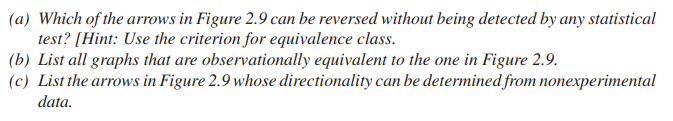
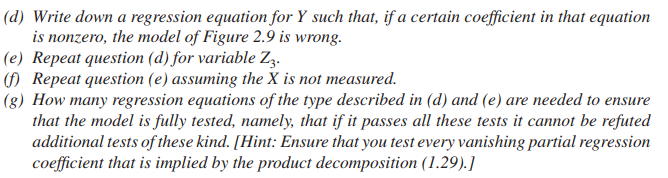

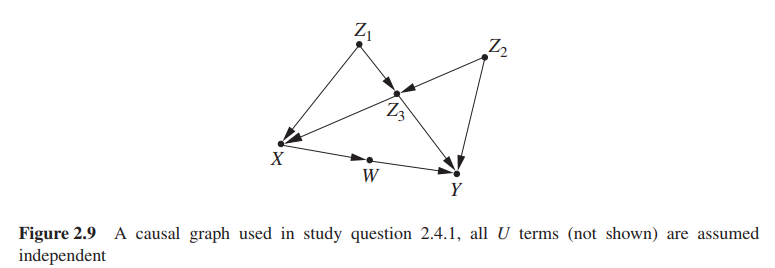

# Solution

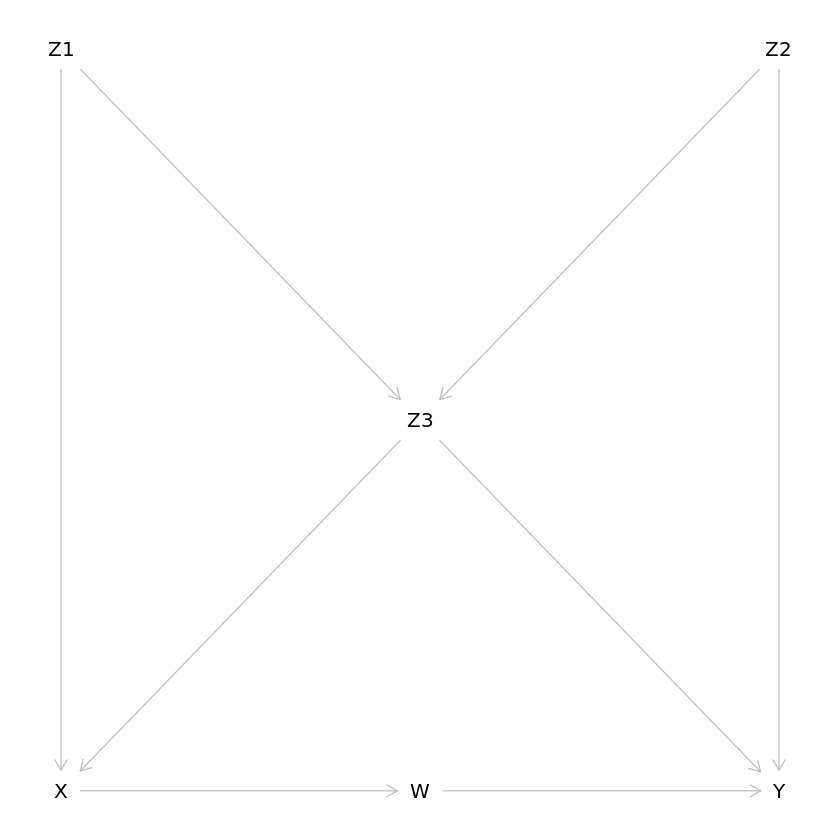

In [2]:
g <- dagitty('dag {
    Z1 -> X
    Z1 -> Z3
    Z2 -> Z3
    Z2 -> Y
    Z3 -> X
    Z3 -> Y
    X -> W
    W -> Y
}')

coordinates(g) <- list(x=c(X=1,W=2,Y=3,Z1=1,Z3=2,Z2=3),
    y=c(X=0,W=0,Y=0,Z2=-2,Z1=-2,Z3=-1))
plot(g)

## (a)

Definition of equivalence classes:

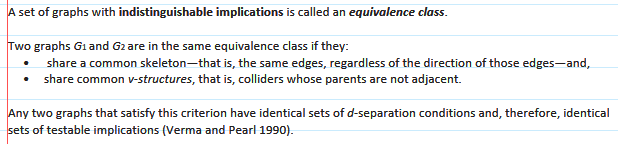

In [3]:
equivalentDAGs(g)

[[1]]
dag {
W [pos="2.000,0.000"]
X [pos="1.000,0.000"]
Y [pos="3.000,0.000"]
Z1 [pos="1.000,-2.000"]
Z2 [pos="3.000,-2.000"]
Z3 [pos="2.000,-1.000"]
W -> Y
X -> W
Z1 -> X
Z1 -> Z3
Z2 -> Y
Z2 -> Z3
Z3 -> X
Z3 -> Y
}


In [4]:
equivalenceClass(g)

pdag {
W [pos="2.000,0.000"]
X [pos="1.000,0.000"]
Y [pos="3.000,0.000"]
Z1 [pos="1.000,-2.000"]
Z2 [pos="3.000,-2.000"]
Z3 [pos="2.000,-1.000"]
W -> Y
X -> W
Z1 -> X
Z1 -> Z3
Z2 -> Y
Z2 -> Z3
Z3 -> X
Z3 -> Y
}

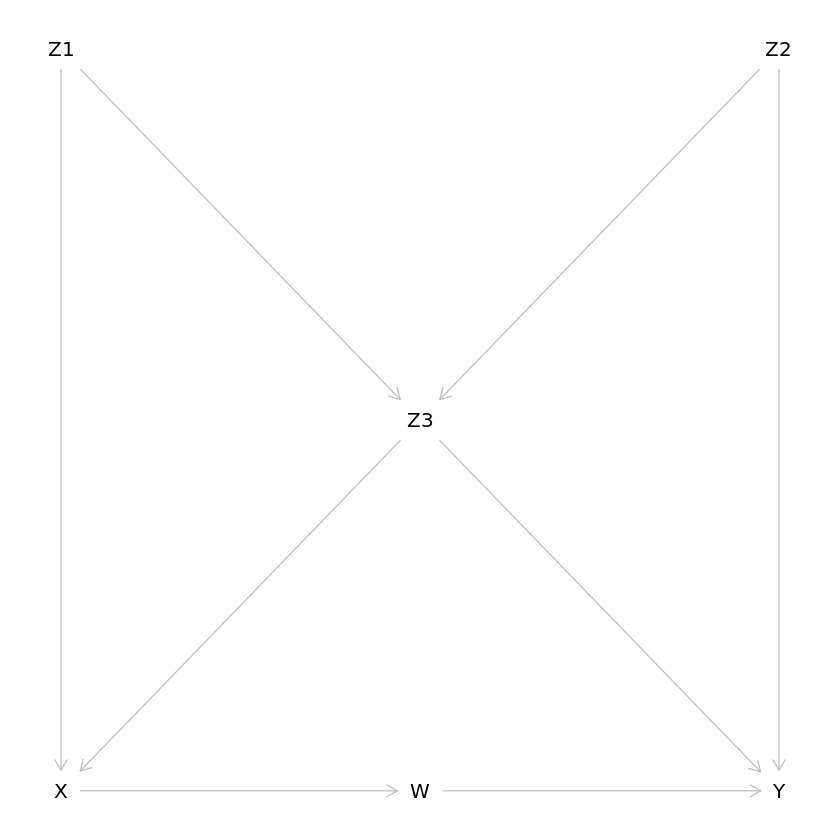

In [5]:
equivalenceClass(g) %>%
    plot

There is only 1 DAG. So no arrows can be reversed without being detected by any statistical test.

### (b)

Not applicable since this DAG has no other equivalence class.

## (c)

Since this DAG has no equivalence class, this means no edge can be reversed such that it will produce an equivalent to this DAG.

Therefore, the directionality of any arrow in this DAG can be determined from non-experimental adta.

## (d)

We can find the which variable is independent of Y:

In [6]:
target_var <- "Y"

predictors <- names(g) %>%
    keep(~ !.x == target_var)

independent_vars <- dseparated(g, target_var, list(), predictors) %>%
    keep(~ !.x == target_var)

independent_vars %>%
    walk(~message(str_interp("${target_var} is independent of ${.x} given ${predictors}")))

Y is independent of X given c("W", "X", "Z1", "Z2", "Z3")

Y is independent of Z1 given c("W", "X", "Z1", "Z2", "Z3")



To find the minimal set:

In [7]:
impliedConditionalIndependencies(g) %>%
    keep(~ .x$X == target_var | .x$Y == target_var) %>%
    iwalk(~ message(str_interp("${.y}. ${.x}")))

5. X _||_ Y | W, Z2, Z3

6. X _||_ Y | W, Z1, Z3

8. Y _||_ Z1 | X, Z2, Z3

9. Y _||_ Z1 | W, Z2, Z3



So one possible regression equation is:

$$Y = aX + bW + cZ_2 + dZ_3 $$

where the value of $a$ must be 0 according to (5).

## (e)

In [8]:
target_var <- "Z3"

impliedConditionalIndependencies(g) %>%
    keep(~ .x$X == target_var | .x$Y == target_var) %>%
    iwalk(~ message(str_interp("${.y}. ${.x}")))

4. W _||_ Z3 | X



## (f)

Make X a latent variable:

In [9]:
latents(g) <- c("X")

Repeat the computation for question (e):

In [10]:
target_var <- "Z3"

impliedConditionalIndependencies(g) %>%
    keep(~ .x$X == target_var | .x$Y == target_var) %>%
    iwalk(~ message(str_interp("${.y}. ${.x}")))

There are no variables that are independent of $Z_3$ when $X$ is not measured!

## (g)

In [11]:
latents(g) <- c() # undo out setting of X as latent from (f)
impliedConditionalIndependencies(g, type="basis.set" )

W _||_ Z1, Z2, Z3 | X
X _||_ Z2 | Z1, Z3
Y _||_ X, Z1 | W, Z2, Z3
Z1 _||_ Z2
Z2 _||_ Z1

Alternative approach:

In [12]:
# for each variable, it's non-descendant nodes should be independent given its parents
f <- function(v){
    desc <- descendants(g, v)
    non_desc <- setdiff(names(g), desc)

    par <- parents(g, v)
    independent_given_parents <- setdiff(non_desc, par)

    independent_given_parents %>%
        map(~ str_interp("${v} is independent of ${.x} given ${par %>% paste(collapse = ', ')}\n"))
}

names(g) %>%
    map(f) %>%
    walk(message)


W is independent of Z1 given X
W is independent of Z2 given X
W is independent of Z3 given X


X is independent of Z2 given Z1, Z3


Y is independent of X given W, Z2, Z3
Y is independent of Z1 given W, Z2, Z3


Z1 is independent of Z2 given 


Z2 is independent of Z1 given 




